# Combining original and flipped segmentations to get purely right-ventricle segmentations

In [1]:
from pathlib import Path
import sys
import math
from typing import List, Tuple

import cv2
import numpy as np
from tqdm import tqdm

import echonet

# print(cv2.getBuildInformation())

Point = List[np.intp]
Box = Tuple[Point, Point, Point, Point]
Rectangle = Tuple[Point, Tuple[float, float], float] # [centre, (width, height), angle]

In [2]:
LEFT_SEGMENT_DIR = Path("output/segmentation/all-patients")
RIGHT_SEGMENT_DIR = Path("output/segmentation/flipped")
ECHONET_VIDEO_DIR = Path("/home/lex/data/echonet-data/Videos")
OUTPUT_DIR = Path("output/right-only-segmentation")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

RED = np.array([255, 0, 0])
GREEN = np.array([0, 255, 0])
BLUE = np.array([0, 0, 255])
ORANGE = np.array([255, 165, 0])
LIGHT_GREY = np.array([211, 211, 211])
MAGENTA = np.array([255, 0, 255])
YELLOW = np.array([255, 255, 0])

DO_SAVE_RIGHT_ONLY_SEGMENTATIONS = False

In [3]:
def get_heights(mask: np.ndarray) -> List[int]:
    """Returns array of heights of mask for each frame!"""
    frame_indices, row_indices = np.where(mask.any(axis=1)==True)

    heights = []
    for frame_index in range(mask.shape[0]):
        this_frame = frame_indices == frame_index

        if len(row_indices[this_frame]) == 0:
            # print(f"Frame #{frame_index} appears to have no segmentations? Treating this as zero height...")
            heights.append(0)
            continue

        min_row, max_row = (min(row_indices[this_frame]), max(row_indices[this_frame]))
        height = max_row - min_row
        heights.append(height)

    heights = np.array(heights)
    return heights

In [4]:
if DO_SAVE_RIGHT_ONLY_SEGMENTATIONS:
    left_segment_mask_fps = [p for p in (LEFT_SEGMENT_DIR / "segmentation_masks").iterdir()]
    for left_segment_mask_fp in tqdm(left_segment_mask_fps):
        # Get associated segment masks for this particular video
        # video_mask_name = video_fp.with_suffix(".npy").name # Turns "path/to/video.avi" into "video.npy"
        video_stem = Path(left_segment_mask_fp.stem) # turns "path/to/0x12345.npy" into just "0x12345"
        right_segment_mask_fp = RIGHT_SEGMENT_DIR / "segmentation_masks" / video_stem.with_suffix(".npy")
        echonet_video_fp = ECHONET_VIDEO_DIR / video_stem.with_suffix(".avi")
        # print(f"Processing {echonet_video_fp}...")

        left_segment_mask = np.load(left_segment_mask_fp)
        right_segment_mask = np.load(right_segment_mask_fp)
        echonet_video = echonet.utils.loadvideo(str(echonet_video_fp)) # (colours, frames, height, width)

        # Since right mask comes from flipped version of video, we need to flip it back to normal (i.e. left-to-right)
        right_segment_mask = np.flip(right_segment_mask, axis=-1)

        # Keep track of the mistaken left ventricle segmentation by the "right" segmentation mask
        mistaken_left_mask = left_segment_mask & right_segment_mask
        # Subtract those mistaken left ventricle parts from the right segmentation
        right_only_mask = right_segment_mask ^ (mistaken_left_mask)

        # Get heights of left and right ventricles, check if right ventricle appears unreasonably large (i.e. probably including atrium accidentally!)
        left_heights = get_heights(left_segment_mask)
        right_heights = get_heights(right_only_mask)
        frames_with_too_large_RV_mask = right_heights > 0.8 * left_heights

        # Put colour channels at end to make it easier to assign pixel colours
        echonet_video = echonet_video.transpose((1, 2, 3, 0)) # I.e. now (frames, height, width, colours)
        echonet_video[left_segment_mask] = RED
        echonet_video[right_only_mask] = BLUE
        echonet_video[mistaken_left_mask] = GREEN
            
        border_thickness = 2
        echonet_video[frames_with_too_large_RV_mask, 0:border_thickness, :] = ORANGE
        echonet_video[frames_with_too_large_RV_mask, -border_thickness:, :] = ORANGE
        echonet_video[frames_with_too_large_RV_mask, :, 0:border_thickness] = ORANGE
        echonet_video[frames_with_too_large_RV_mask, :, -border_thickness:] = ORANGE

        # Transpose video back to original shape now and save
        echonet_video = echonet_video.transpose((3, 0, 1, 2)) # now (colours, frames, height, width) as before
        output_fp = OUTPUT_DIR / video_stem.with_suffix(".avi")

        echonet.utils.savevideo(str(output_fp), echonet_video, 30)

# Filtering out garbage data
Here, we'll be trying to discard any videos that are not A4C views.

In [5]:
def mask_to_image(mask: np.ndarray, max_val: int = 255) -> np.ndarray:
    """
    Converts a boolean mask array to a pure black and white image. Useful if
    you start with a mask but then want to find contours and perform other image
    analysis on that mask    
    """
    return mask.astype(np.uint8) * max_val

def image_to_mask(image: np.ndarray, threshold: int = 1) -> np.ndarray:
    """
    Converts a black and white image to a boolean mask, selecting every pixel 
    whose intensity is **greater than or equal to the threshold**
    """
    return image >= threshold

In [6]:
VIDEONAME = "0X1A58C9DFE12C7953"

LEFT_SEGMENTATION_MASK_FP = Path(f"/home/lex/Development/ultrasound/output/segmentation/all-patients/segmentation_masks/{VIDEONAME}.npy")
FLIPPED_SEGMENTATION_MASK_FP = Path(f"/home/lex/Development/ultrasound/output/segmentation/flipped/segmentation_masks/{VIDEONAME}.npy")
ECHONET_VIDEO_FP = Path(f"/home/lex/data/echonet-data/Videos/{VIDEONAME}.avi")

left_segmentation_masks = np.load(LEFT_SEGMENTATION_MASK_FP)
flipped_segmentation_masks = np.load(FLIPPED_SEGMENTATION_MASK_FP)
flipped_segmentation_masks = np.flip(flipped_segmentation_masks, -1) # Flip back to original orientation

# Subtract those mistaken left ventricle parts from the right segmentation
right_segmentation_masks = flipped_segmentation_masks & ~left_segmentation_masks
# intersection_mask = left_segmentation_masks & flipped_segmentation_masks
# right_segmentation_masks = flipped_segmentation_masks ^ intersection_mask

left_segmentations = mask_to_image(left_segmentation_masks)
right_segmentations = mask_to_image(right_segmentation_masks)

echonet_video = echonet.utils.loadvideo(str(ECHONET_VIDEO_FP))
echonet_video = echonet_video.transpose((1, 2, 3, 0))

num_frames, height, width, num_channels = echonet_video.shape

In [7]:
def make_line(p1: Point, p2: Point, xs: List[int]) -> List[Point]:
    """
    Extends a line between the given pair of points for all given x values and
    returns the list of points on this line.
    
    This clips the points for you in case any of the given x values correspond to
    y values outside of the image's borders.
    """
    x1, y1 = p1
    x2, y2 = p2
    
    gradient = (y2 - y1) / (x2 - x1)
    ys = gradient * (xs - x1) + y1
    ys = np.intp(ys)
    
    all_points = list(zip(xs, ys))
    points_within_frame = []
    # Only include points that would be within the image's borders
    for point in all_points:
        x, y = point
        if (0 <= x < width) and (0 <= y < height):
            points_within_frame.append(point)

    return points_within_frame

In [8]:
def get_min_area_rect(image: np.ndarray) -> Rectangle:
    """
    Finds the largest contour in the given image, and returns the minimum area
    rectangle that bounds it.

    Returns
    -------
    ((centre_x, centre_y), (width, height), angle)
    """
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assume we're only interested in max area contour
    areas = [cv2.contourArea(cnt) for cnt in contours]
    max_index = np.argmax(areas)
    biggest_contour = contours[max_index]

    min_area_rect = cv2.minAreaRect(biggest_contour)
    return min_area_rect

In [9]:
def get_min_area_box(image: np.ndarray) -> Box:
    """
    Similar to get_min_area_rect(), but instead returns the coordinates of the
    box's four corners.
    """
    min_area_rect = get_min_area_rect(image)
    box = np.intp(cv2.boxPoints(min_area_rect))
    
    return box

In [10]:
def perpendicular_distance_to_line(line: List[List[int]], point: List[int]) -> float:
    """
    Returns the perpendicular distance from a straight line to a given point.

    Parameters
    ----------
    line: List[List[int]]
        `line` is a *pair* of points, where each point contains a single x and y
        value.
    point: List[int]
        A pair of x and y values.
    """
    (x1, y1), (x2, y2) = line
    x3, y3 = point

    m = (y2 -y1) / (x2 - x1)
    a = -1
    b = 1 / m
    c = x1 - y1 / m

    d = abs(a * x3 + b * y3 + c) / math.sqrt(a**2 + b**2)
    return d

In [11]:
# Define LV boxes and rectangles
LV_boxes = [get_min_area_box(left_segmentation) for left_segmentation in left_segmentations]
LV_rects = [get_min_area_rect(left_segmentation) for left_segmentation in left_segmentations]
LV_lines = [[box[0], box[3]] for box in LV_boxes]

In [12]:
# Only include largest contour of right segmentation for each frame. This removes
# any smaller, disconnected blobs
right_segmentations_copy = right_segmentations.copy()
right_segmentations = np.zeros(right_segmentations.shape, dtype=right_segmentations.dtype)
for i, right_segmentation in enumerate(right_segmentations_copy):
    right_contours, hierarchy = cv2.findContours(right_segmentation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in right_contours]
    max_index = np.argmax(areas)
    biggest_contour = right_contours[max_index]

    biggest_right_segmentation = np.zeros(right_segmentation.shape)
    biggest_right_segmentation = cv2.drawContours(biggest_right_segmentation, [biggest_contour], -1, 255, -1)
    right_segmentations[i] = biggest_right_segmentation

# Update masks too, would be nicer to have these masks and images automatically linked though!
right_segmentation_masks = image_to_mask(right_segmentations)

In [13]:
# Trim RV segmentations based on LV bounding box
right_segmentations = np.zeros(shape=right_segmentations.shape, dtype=right_segmentations.dtype)

bottom_cutoff_points_list = []
top_cutoff_points_list = []
right_cutoff_points_list = []

cutoff_x = np.intp(np.arange(0, width))

for i, (LV_box, right_segmentation_mask) in enumerate(zip(LV_boxes, right_segmentation_masks)):
    top_left_LV, top_right_LV, bottom_right_LV, bottom_left_LV = LV_box

    bottom_cutoff_points = make_line(bottom_left_LV, bottom_right_LV, cutoff_x)
    bottom_cutoff_points_list.append(bottom_cutoff_points)

    top_cutoff_points = make_line(top_left_LV, top_right_LV, cutoff_x)
    top_cutoff_points_list.append(top_cutoff_points)

    right_cutoff_points = make_line(bottom_left_LV, top_left_LV, cutoff_x)
    right_cutoff_points_list.append(right_cutoff_points)

    # Note we update the masks here, so we don't need to call image_to_mask()
    # at end of this for loop!
    for x, y in bottom_cutoff_points:
        right_segmentation_mask[y:, x] = False
    for x, y in right_cutoff_points:
        right_segmentation_mask[:y, x] = False

    right_segmentations[i] = mask_to_image(right_segmentation_mask)


In [14]:
# Calculate RV areas
# Since we have already eliminated all but the largest contour, we simply always
# use hardcoded index of 0 to access it!
# Then extra index zero for contours because of opencv's return values
RV_contours_list = [cv2.findContours(frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0][0] for frame in right_segmentations]
RV_areas = [cv2.contourArea(contour) for contour in RV_contours_list]

In [15]:
# # Calculate angle for bounding box of LV in each frame
# LV_box_angles = np.zeros(num_frames)
# for i, left_segmentation in enumerate(left_segmentations):
#     *_, angle = get_min_area_rect(left_segmentation)
#     LV_box_angles[i] = angle

# print(f"Mean LV box angle: {np.mean(LV_box_angles)} +/- {np.std(LV_box_angles)}")

# # Check how many times the box goes beyond three standard deviations
# mean, std = np.mean(LV_box_angles), np.std(LV_box_angles)
# bad_angle_mask = (LV_box_angles < mean - 1 * std) | ((LV_box_angles > mean + 1 * std))
# num_bad_angles = bad_angle_mask.sum()
# print(f"Found {num_bad_angles} frames with suspicious LV bounding box angles")

In [16]:
def find_bottom_right(rect: Rectangle) -> Point:
    """
    (Attempts to) find the "bottom-right" corner of the given rectangle. This 
    can at least handle rectangles rotated by an angle in the range [0, 90).
    """
    angle = rect[-1]
    box = np.intp(cv2.boxPoints(rect))

    if angle <= 0:
        return box[3]
    else:
        return box[2]

In [17]:
# Find septum widths
septum_widths = []

for right_segmentation, LV_line in zip(right_segmentations, LV_lines):
    RV_rect = get_min_area_rect(right_segmentation)
    RV_bottom_right = find_bottom_right(RV_rect)

    x3, y3 = RV_bottom_right
    # frame[y3:y3+2, x3:x3+2] = ORANGE
    septum_width = perpendicular_distance_to_line(LV_line, RV_bottom_right)
    septum_widths.append(septum_width)
    # print(f"Septum: {septum_width}")

print(f"Mean septum width: {np.mean(septum_widths)} +/- {np.std(septum_widths)}")

Mean septum width: 6.467814675960786 +/- 1.5488343224252616


(array([ 1.,  1.,  0.,  1., 10., 29., 24., 20., 15.,  7.]),
 array([0.17005365, 1.13139026, 2.09272687, 3.05406349, 4.0154001 ,
        4.97673671, 5.93807332, 6.89940994, 7.86074655, 8.82208316,
        9.78341977]),
 <BarContainer object of 10 artists>)

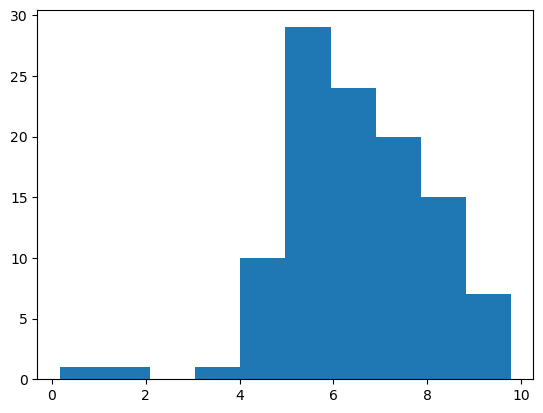

In [18]:
import matplotlib.pyplot as plt

plt.hist(septum_widths, bins=10)

In [19]:
# Use average estimated septum width and translate the LV segmentation's inner
# edge by that amount to guess the right edge of the RV.
mean_septum_width = np.mean(septum_widths)

RV_boxes = []
RV_lines = []
for LV_box, LV_rect, LV_line, right_segmentation_mask, right_segmentation in zip(LV_boxes, LV_rects, LV_lines, right_segmentation_masks, right_segmentations):
    LV_angle = LV_rect[-1]
    
    # Since we translate points *left*, and not necessarily perpendicular to LV
    # line, we include factor of sin(angle)
    translate_x = mean_septum_width / math.sin(math.radians(LV_angle))
    RV_line = [point.copy() for point in LV_line]
    for point in RV_line:
        point[0] -= translate_x

    RV_lines.append(RV_line)

    RV_box = get_min_area_box(right_segmentation)
    # Just in case we need to access this later
    RV_boxes.append(RV_box)

    # Now remove any pixels in RV segmentation that go beyond its expected inner
    # edge
    # Note this is a greedier "right cutoff" than before, should probs just name this better!
    right_cutoff_points = make_line(RV_line[0], RV_line[1], cutoff_x)
    for x, y in right_cutoff_points:
        right_segmentation_mask[:y, x] = False

# Update RV segmentation *images* based on these new masks
right_segmentations = mask_to_image(right_segmentation_masks)

In [20]:
WINDOW = "Mask"
cv2.namedWindow(WINDOW, cv2.WINDOW_NORMAL)

i = 0
is_playing = True


while True:
    if i >= num_frames:
        i = 0
        print("Video looped!")
    elif i < 0:
        i = num_frames - 1

    # Copy data for this particular frame
    frame = echonet_video[i].copy()
    left_segmentation_mask = left_segmentation_masks[i].copy()
    left_segmentation = left_segmentations[i].copy()
    right_segmentation_mask = right_segmentation_masks[i].copy()
    right_segmentation = right_segmentations[i].copy()

    this_area = RV_areas[i]
    LV_line = LV_lines[i]
    RV_line = RV_lines[i]
    LV_box = LV_boxes[i]
    RV_box = RV_boxes[i]

    # 
    if i > 0: 
        prev_area = RV_areas[i - 1]
        growth = this_area / prev_area
        # print(f"RV Area growth: {growth:.2f}")
        # if growth > 1.2:
        #     frame[:10, :] = ORANGE

    # Add any drawings to the ultrasound here
    frame[left_segmentation_mask] = RED
    frame[right_segmentation_mask] = BLUE
    # Note this draws the outdated RV_box, before we cut out the septum!
    cv2.drawContours(frame,[RV_box],0, YELLOW.tolist())
    cv2.drawContours(frame,[LV_box],0, YELLOW.tolist())
    cv2.line(frame, np.intp(LV_line[0]), np.intp(LV_line[1]), ORANGE.tolist())
    cv2.line(frame, np.intp(RV_line[0]), np.intp(RV_line[1]), RED.tolist())

    top_border = np.zeros((height // 8, width, 3), dtype=frame.dtype)
    top_border[:, :] = np.expand_dims(LIGHT_GREY, (0, 1))
    cv2.putText(top_border, f"Frame {i+1}/{num_frames}", org=(5,10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.25, color=(255, 0, 0))
    frame = np.concatenate([top_border, frame], axis=0)
    frame = np.flip(frame, -1)
    cv2.imshow(WINDOW, frame)

    keypress = cv2.waitKey(50) & 0xFF
    if keypress == ord('q'):
        break
    elif keypress == ord(' '):
        is_playing = not is_playing
    elif keypress == ord('a'):
        i -= 1
    elif keypress == ord('d'):
        i += 1
    else:
        if is_playing:
            i += 1

cv2.destroyAllWindows()